In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from utils import load_image, add_noise, plot_image
import models

Using cache found in /home/duffy.se/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


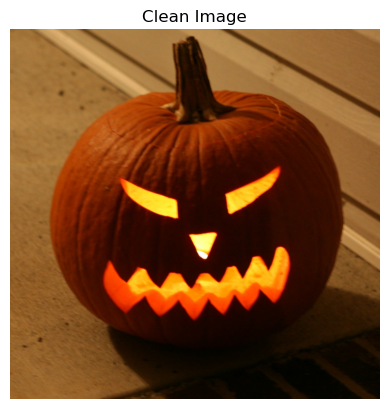

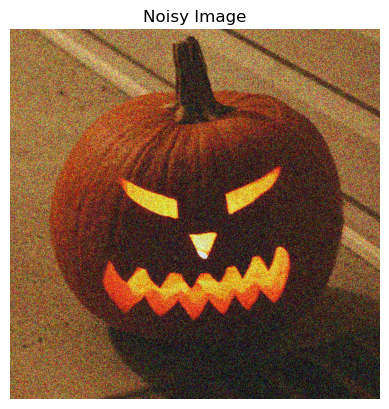

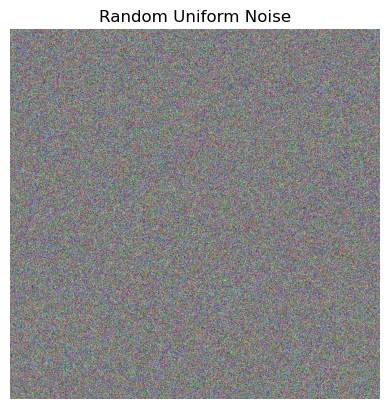

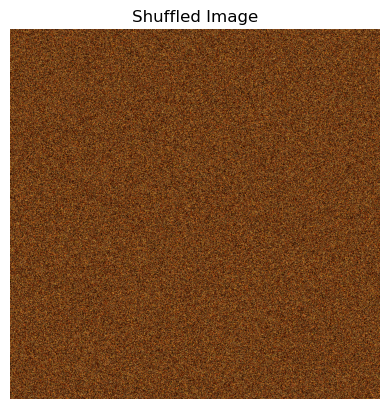

In [9]:
# Load and add noise
w = 1024
h = w
image_path = 'data/jack-o-lantern.jpg'
clean_image = load_image(image_path, target_size=(1024, 1024), tensor=True).to(device)
noisy_image = add_noise(clean_image, noise_factor=0.3).unsqueeze(0).to(device)
noise = torch.rand_like(clean_image).uniform_(0, 1).unsqueeze(0).to(device)

shuffled = clean_image.view(-1, clean_image.size(1) * clean_image.size(2))
shuffled = shuffled[:, torch.randperm(shuffled.size(1))]
shuffled = shuffled.view(clean_image.size()).unsqueeze(0).to(device)

# Plot all four images together
plot_image(clean_image.unsqueeze(0).to(device), title='Clean Image')
plot_image(noisy_image, title='Noisy Image')
plot_image(noise, title='Random Uniform Noise')
plot_image(shuffled, title='Shuffled Image')

In [5]:
# Hyperparameters
z_shape = (1, 32, w, h)
z = torch.rand(z_shape).uniform_(0, 0.1).to(device)
nu = nd = [128, 128, 128, 128, 128]
ku = kd = [3, 3, 3, 3, 3]
ns = [4, 4, 4, 4, 4]
ks = [1, 1, 1, 1, 1]
sigma_p = 1 / 30
epochs = 500
lr = 0.01
upsampling = 'bilinear'
loss_function = nn.MSELoss()

In [6]:
loss_df = pd.DataFrame()

Epoch [0/500] Loss: 0.186493


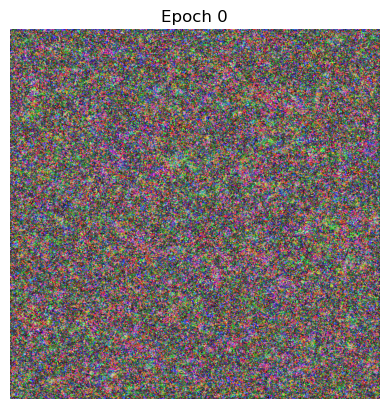

Epoch [100/500] Loss: 0.054224


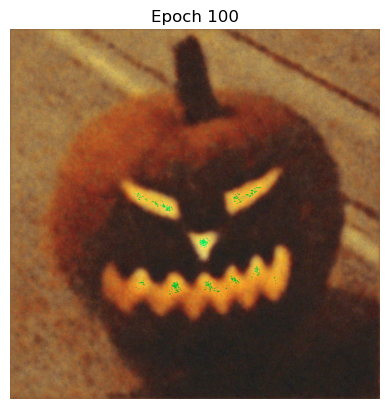

Epoch [200/500] Loss: 0.052883


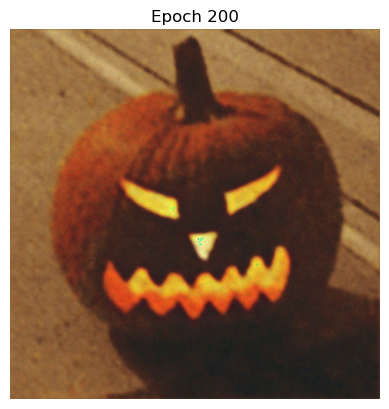

Epoch [300/500] Loss: 0.052480


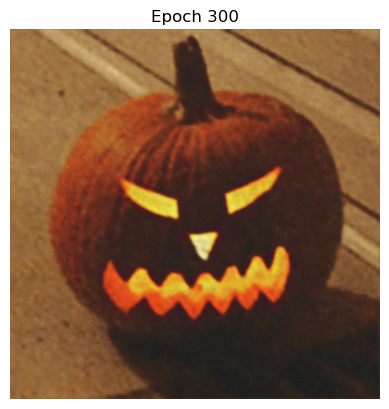

Epoch [400/500] Loss: 0.052279


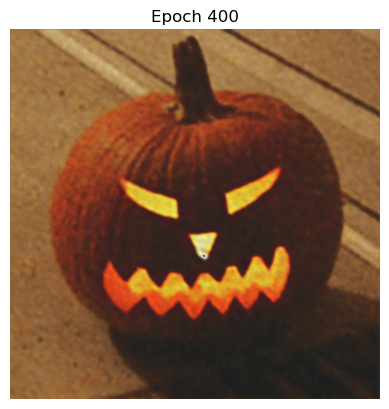

Epoch [499/500] Loss: 0.052125


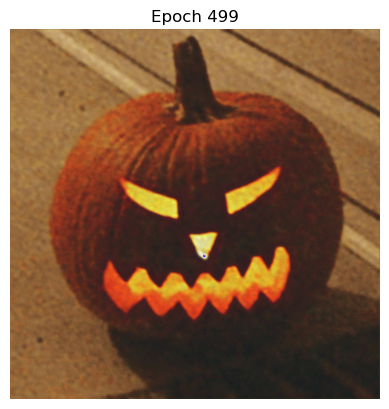

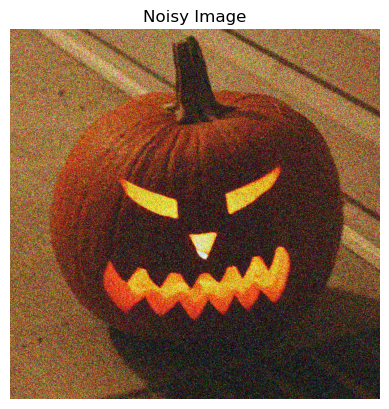

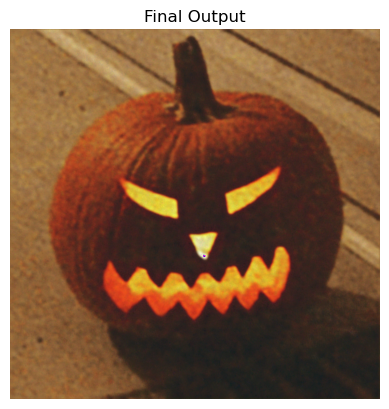

In [7]:
model = models.DeepImagePriorNet(nd=nd, kd=kd, nu=nu, ku=ku, ns=ns, ks=ks, d_in=z_shape, upsampling=upsampling).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    z += torch.randn_like(z) * sigma_p
    output = model(z)

    loss = loss_function(output, noisy_image)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    

    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item():.6f}")
        with torch.no_grad():
            output_image = output
            plot_image(output_image, title=f"Epoch {epoch}")

loss_df['Noisy Image'] = losses
plot_image(noisy_image, title='Noisy Image')
plot_image(output_image, title='Final Output')

In [10]:
model = models.DeepImagePriorNet(nd=nd, kd=kd, nu=nu, ku=ku, ns=ns, ks=ks, d_in=z_shape, upsampling=upsampling).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    z += torch.randn_like(z) * sigma_p
    output = model(z)

    loss = loss_function(output, clean_image)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    

    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item():.6f}")
        with torch.no_grad():
            output_image = output
            #plot_image(output_image, title=f"Epoch {epoch}")

loss_df['Clean Image'] = losses

Epoch [0/500] Loss: 0.175407
Epoch [100/500] Loss: 0.001609
Epoch [200/500] Loss: 0.000781
Epoch [300/500] Loss: 0.000533
Epoch [400/500] Loss: 0.000408
Epoch [499/500] Loss: 0.000331


In [11]:
model = models.DeepImagePriorNet(nd=nd, kd=kd, nu=nu, ku=ku, ns=ns, ks=ks, d_in=z_shape, upsampling=upsampling).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    z += torch.randn_like(z) * sigma_p
    output = model(z)

    loss = loss_function(output, noise)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    

    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item():.6f}")
        with torch.no_grad():
            output_image = output
            #plot_image(output_image, title=f"Epoch {epoch}")

loss_df['Noise'] = losses

Epoch [0/500] Loss: 0.684289
Epoch [100/500] Loss: 0.083547
Epoch [200/500] Loss: 0.083362
Epoch [300/500] Loss: 0.083211
Epoch [400/500] Loss: 0.082925
Epoch [499/500] Loss: 0.082479


In [12]:
model = models.DeepImagePriorNet(nd=nd, kd=kd, nu=nu, ku=ku, ns=ns, ks=ks, d_in=z_shape, upsampling=upsampling).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    z += torch.randn_like(z) * sigma_p
    output = model(z)

    loss = loss_function(output, shuffled)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()
    

    if epoch % 100 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch}/{epochs}] Loss: {loss.item():.6f}")
        with torch.no_grad():
            output_image = output
            #plot_image(output_image, title=f"Epoch {epoch}")

loss_df['Shuffled Image'] = losses

Epoch [0/500] Loss: 0.331077
Epoch [100/500] Loss: 0.042385
Epoch [200/500] Loss: 0.042256
Epoch [300/500] Loss: 0.042197
Epoch [400/500] Loss: 0.042145
Epoch [499/500] Loss: 0.042065


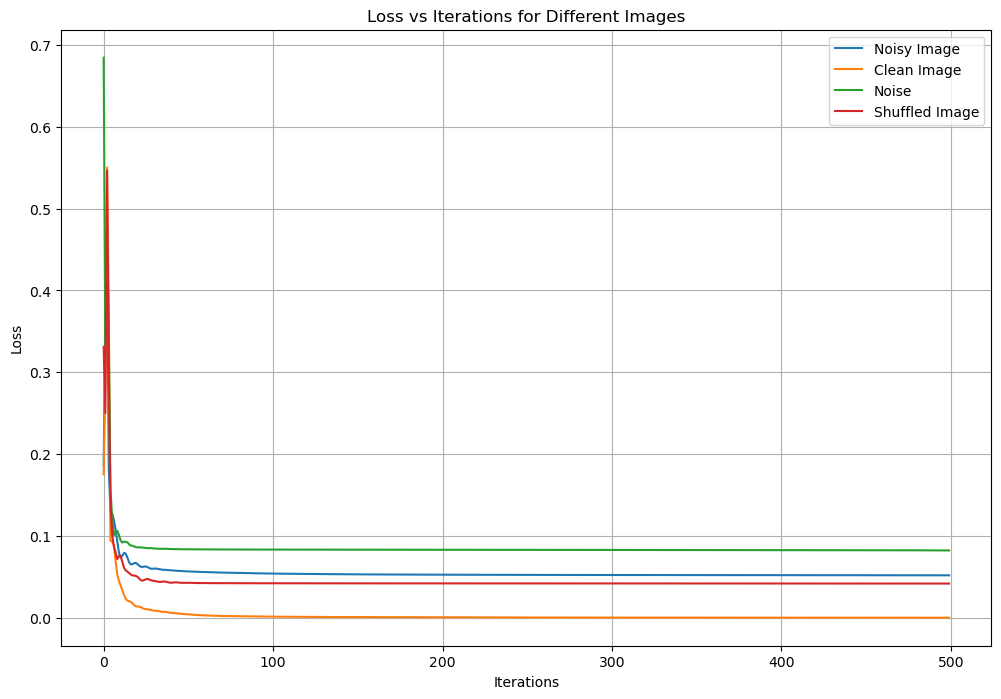

In [13]:
plt.figure(figsize=(12, 8))
for image_name in loss_df.columns:
    plt.plot(loss_df[image_name], label=image_name)

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations for Different Images')
plt.legend()
plt.grid(True)
plt.show()